<a href="https://colab.research.google.com/github/SnigdhaP2022/ATM-interface/blob/main/Assignment2_48448737.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# --- Introduction ---
"""
This Jupyter Notebook implements an image classification system for the Rock-Paper-Scissors dataset.
It covers data exploration, preparation, model building (both custom ConvNet and pre-trained),
training, evaluation, and deployment to a webcam for real-time classification.
"""

In [ ]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
# Define the base directory where the dataset is located
base_dir = '/Users/snigdhapatibandla/Downloads/Assignment2_project/Rock-Paper-Scissors'
train_dir = base_dir

# Load the provided CSV files
train_df = pd.read_csv('train.csv')
devtest_df = pd.read_csv('devtest.csv')
test_df = pd.read_csv('test.csv')



# Task 1 - Exploration (2 marks)

This task focuses on exploring the Rock-Paper-Scissors image classification dataset.
We will examine the structure of the dataset, visualize sample images, and analyze
the distribution of images across different classes and partition sets (train, devtest, test).
"""


## 1.1 Exploration

In this section, we will write code to perform the following subtasks:

* For each partition set (train, devtest, test) and class name, display one image and print the dimensions of its corresponding NumPy array.
* Determine the number of images per class in each set.
* Assess if there are significant differences between the proportions of images in each set.
"""

In [ ]:
# Define class names
class_names = ['rock', 'paper', 'scissors']
class_to_index = {'rock': 0, 'paper': 1, 'scissors': 2}
index_to_class = {0: 'rock', 1: 'paper', 2: 'scissors'}

def display_image_and_shape(df, set_name, base_path):
    """Displays one image per class and prints its shape."""
    print(f"--- {set_name} Set ---")
    for class_name in class_names:
        class_df = df[df['label'] == class_name].iloc[0]
        img_path = os.path.join(base_path, class_df['path']) # Use 'path' directly as it contains the class subdirectory

        try:
            img = Image.open(img_path)
            img_array = np.array(img)
            plt.imshow(img)
            plt.title(f"{set_name} - {class_name}")
            plt.axis('off')
            plt.show()
            print(f"Shape of {class_name} image in {set_name}: {img_array.shape}")
        except FileNotFoundError:
            print(f"Error: Image not found at {img_path}")

def count_images_per_class(df, set_name):
    """Counts the number of images per class in a given set."""
    print(f"\n--- Image Counts in {set_name} Set ---")
    counts = df['label'].value_counts().sort_index()
    print(counts)

Task 1.1: Exploration
--- Train Set ---


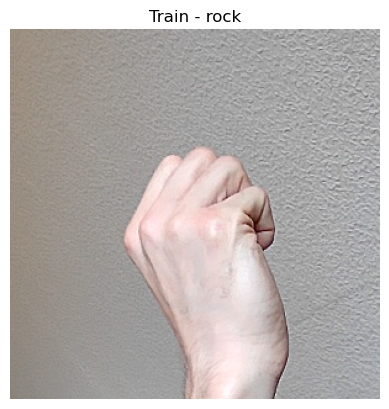

Shape of rock image in Train: (300, 300, 3)


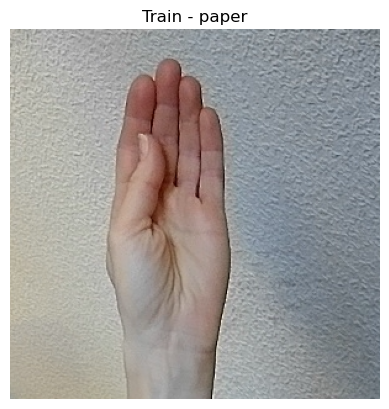

Shape of paper image in Train: (300, 300, 3)


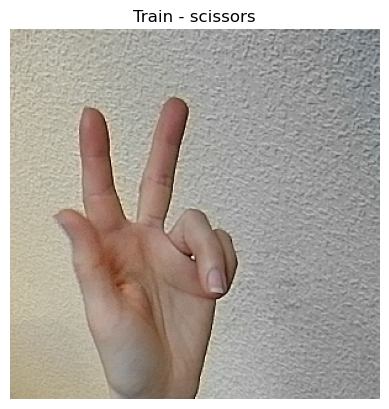

Shape of scissors image in Train: (300, 300, 3)
--- Devtest Set ---


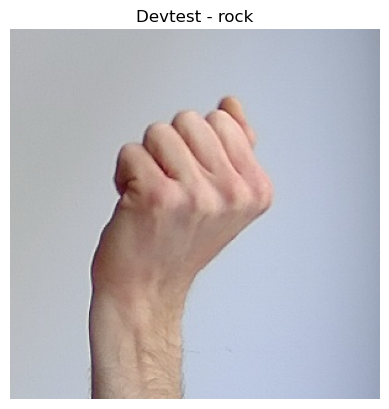

Shape of rock image in Devtest: (300, 300, 3)


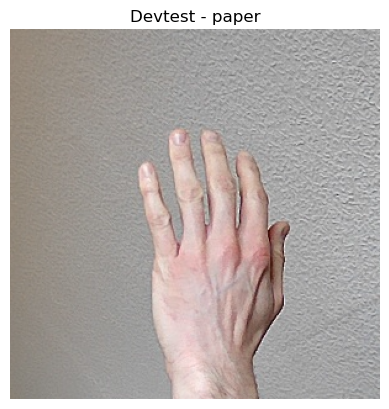

Shape of paper image in Devtest: (300, 300, 3)


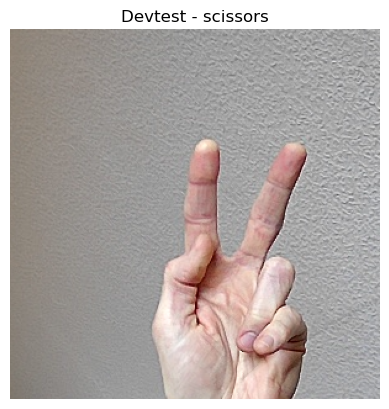

Shape of scissors image in Devtest: (300, 300, 3)
--- Test Set ---


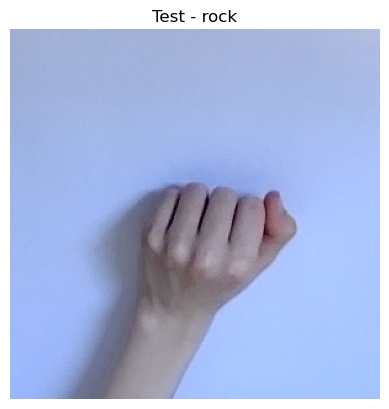

Shape of rock image in Test: (300, 300, 3)


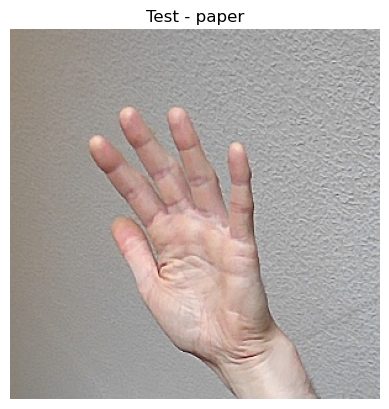

Shape of paper image in Test: (300, 300, 3)


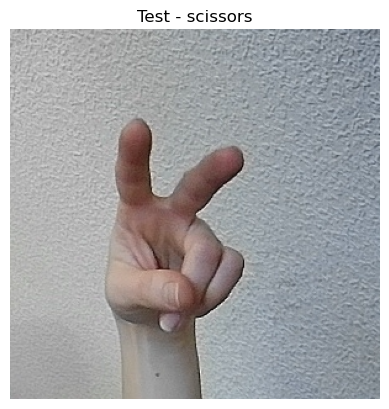

Shape of scissors image in Test: (300, 300, 3)

--- Image Counts in Train Set ---
label
paper       544
rock        544
scissors    541
Name: count, dtype: int64

--- Image Counts in Devtest Set ---
label
paper       181
rock        181
scissors    180
Name: count, dtype: int64

--- Image Counts in Test Set ---
label
paper       182
rock        182
scissors    182
Name: count, dtype: int64


In [ ]:
# 1.1 Exploration
print("Task 1.1: Exploration")

# Display one image and shape for each set and class
display_image_and_shape(train_df, 'Train', train_dir)
display_image_and_shape(devtest_df, 'Devtest', train_dir)
display_image_and_shape(test_df, 'Test', train_dir)

# Determine the number of images per class in each set
count_images_per_class(train_df, 'Train')
count_images_per_class(devtest_df, 'Devtest')
count_images_per_class(test_df, 'Test')


### Analysis of Proportions

In this section, we calculate the proportion of images belonging to each class
within each of the train, devtest, and test sets. This helps us determine if the
distribution of classes is consistent across the different partitions.

In [ ]:
# --- Analysis of Proportions ---
print("\n--- Analysis of Proportions ---")
train_counts = train_df['label'].value_counts(normalize=True).sort_index()
devtest_counts = devtest_df['label'].value_counts(normalize=True).sort_index()
test_counts = test_df['label'].value_counts(normalize=True).sort_index()

print("Proportions in Train Set:\n", train_counts)
print("\nProportions in Devtest Set:\n", devtest_counts)
print("\nProportions in Test Set:\n", test_counts)


--- Analysis of Proportions ---
Proportions in Train Set:
 label
paper       0.333947
rock        0.333947
scissors    0.332106
Name: proportion, dtype: float64

Proportions in Devtest Set:
 label
paper       0.333948
rock        0.333948
scissors    0.332103
Name: proportion, dtype: float64

Proportions in Test Set:
 label
paper       0.333333
rock        0.333333
scissors    0.333333
Name: proportion, dtype: float64


## 1.2 Preparation

This section focuses on preparing the dataset for training using PyTorch.
The steps involved include:

* Creating a custom PyTorch Dataset class (`RPSDataset`) to handle loading images and their labels.
* Defining data transformations to resize images to 100x100 pixels and rescale pixel values to the range [0, 1] using `torchvision.transforms`.
* Creating PyTorch DataLoaders for the training, devtest, and test datasets to enable efficient batching and shuffling of the data during training.

In [ ]:
class RPSDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path_relative = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['label']
        img_path = os.path.join(self.img_dir, img_path_relative) # Use the full relative path

        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, class_to_index[label]
        except FileNotFoundError:
            print(f"Error: Image not found at {img_path}")
            return None, None

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Rescale to [-1, 1] then we will handle 0-1 later if needed
])

# Create datasets
train_dataset = RPSDataset(train_df, train_dir, transform=transform)
devtest_dataset = RPSDataset(devtest_df, train_dir, transform=transform)
test_dataset = RPSDataset(test_df, train_dir, transform=transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
devtest_loader = DataLoader(devtest_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print("\nDatasets and DataLoaders created successfully.")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of devtest samples: {len(devtest_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")


Datasets and DataLoaders created successfully.
Number of training samples: 1629
Number of devtest samples: 542
Number of test samples: 546
Batch size: 32
